In [5]:
from PIL import Image

img = Image.open(r"C:.\Nutrition5K\Nutrition5K\train\color\dish_0000\rgb.png")
print(img.size)  # 输出 (W, H)

(640, 480)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvBNReLU(nn.Module):
    """Basic conv block: Conv -> BN -> ReLU"""
    def __init__(self, in_ch, out_ch, k=3, s=1, p=1):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, k, stride=s, padding=p, bias=False)
        self.bn   = nn.BatchNorm2d(out_ch, eps=1e-5, momentum=0.1)
        self.act  = nn.ReLU(inplace=True)
    def forward(self, x):
        return self.act(self.bn(self.conv(x)))

class TinyCNN(nn.Module):
    """
    Ultra-small CNN for RGB-D regression.
    - Early fusion: set in_ch=4 to accept RGB(3)+Depth(1)
    - By default uses standard GAP (no mask).
    - You can enable masked-GAP later via use_mask=True and passing a mask tensor to forward().
    """
    def __init__(self, in_ch=4, widths=(24, 48, 96, 128), dropout=0.3, out_dim=1, use_mask: bool=False):
        super().__init__()
        self.use_mask = use_mask
        w1, w2, w3, w4 = widths

        # Stem -> H/2
        self.stem = nn.Sequential(
            ConvBNReLU(in_ch, w1, k=3, s=2, p=1),
            ConvBNReLU(w1, w1, k=3, s=1, p=1),
        )
        # Stage1 -> H/4
        self.stage1 = nn.Sequential(
            ConvBNReLU(w1, w2, k=3, s=2, p=1),
            ConvBNReLU(w2, w2, k=3, s=1, p=1),
        )
        # Stage2 -> H/8
        self.stage2 = nn.Sequential(
            ConvBNReLU(w2, w3, k=3, s=2, p=1),
            ConvBNReLU(w3, w3, k=3, s=1, p=1),
        )
        # Stage3 -> H/16
        self.stage3 = nn.Sequential(
            ConvBNReLU(w3, w4, k=3, s=2, p=1),
            ConvBNReLU(w4, w4, k=3, s=1, p=1),
        )

        # Head: GAP/Masked-GAP -> Dropout -> MLP(128) -> Linear(out_dim)
        self.dropout = nn.Dropout(dropout)
        self.fc1     = nn.Linear(w4, 128)
        self.fc2     = nn.Linear(128, out_dim)  # regression head (no activation)

    def forward_features(self, x):
        x = self.stem(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)   # [B, C, H/16, W/16]
        return x

    @staticmethod
    def masked_gap(feat: torch.Tensor, mask: torch.Tensor | None):
        """
        Optional masked global average pooling.
        If mask is None, this falls back to standard GAP outside this method.
        """
        if mask is None:
            # Should not be called when mask=None; kept for completeness.
            return F.adaptive_avg_pool2d(feat, 1).flatten(1)
        m = F.interpolate(mask, size=feat.shape[-2:], mode="nearest").clamp(0, 1)  # [B,1,Hf,Wf]
        num = (feat * m).sum(dim=(2,3))           # [B,C]
        den = (m.sum(dim=(2,3)) + 1e-6)           # [B,1]
        return num / den

    def forward(self, x, mask: torch.Tensor | None = None):
        """
        x:    [B, in_ch, H, W]  (e.g., in_ch=4 for RGB-D)
        mask: [B, 1, H, W] or None. Ignored unless self.use_mask is True.
        """
        f = self.forward_features(x)
        if self.use_mask:
            # Use masked-GAP ONLY when explicitly enabled and mask is provided.
            pooled = self.masked_gap(f, mask)
        else:
            # Standard GAP (default baseline, no mask involved).
            pooled = F.adaptive_avg_pool2d(f, 1).flatten(1)

        z = self.dropout(pooled)
        z = F.relu(self.fc1(z), inplace=True)
        out = self.fc2(z)  # [B, out_dim]
        return out

# ------- tiny self-test -------
if __name__ == "__main__":
    B, H, W = 4, 640, 480
    # Default: no mask path (use_mask=False)
    model = TinyCNN(in_ch=6, widths=(24,48,96,128), dropout=0.3, out_dim=1, use_mask=False)
    x = torch.randn(B, 4, H, W)
    y = model(x)
    print("Output (no mask) shape:", y.shape)

    # # Later: enable masked-GAP easily
    # model_mask = TinyCNN(in_ch=4, widths=(24,48,96,128), dropout=0.3, out_dim=1, use_mask=True)
    # m = torch.randint(0, 2, (B, 1, H, W)).float()
    # y2 = model_mask(x, mask=m)
    # print("Output (with mask) shape:", y2.shape)

In [17]:
import os, csv, random, math, time
from typing import Tuple, Optional
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms.functional as TF
from PIL import Image
import matplotlib.pyplot as plt

# ---------------------- TinyCNN ----------------------
class ConvBNReLU(nn.Module):
    def __init__(self, in_ch, out_ch, k=3, s=1, p=1):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, k, stride=s, padding=p, bias=False)
        self.bn   = nn.BatchNorm2d(out_ch, eps=1e-5, momentum=0.1)
        self.act  = nn.ReLU(inplace=True)
    def forward(self, x): return self.act(self.bn(self.conv(x)))

class TinyCNN(nn.Module):
    def __init__(self, in_ch=6, widths=(24,48,96,128), dropout=0.3, out_dim=1, use_mask: bool=False):
        super().__init__()
        self.use_mask = use_mask
        w1,w2,w3,w4 = widths
        self.stem  = nn.Sequential(ConvBNReLU(in_ch,w1,3,2,1), ConvBNReLU(w1,w1,3,1,1))
        self.s1    = nn.Sequential(ConvBNReLU(w1,w2,3,2,1),  ConvBNReLU(w2,w2,3,1,1))
        self.s2    = nn.Sequential(ConvBNReLU(w2,w3,3,2,1),  ConvBNReLU(w3,w3,3,1,1))
        self.s3    = nn.Sequential(ConvBNReLU(w3,w4,3,2,1),  ConvBNReLU(w4,w4,3,1,1))
        self.drop  = nn.Dropout(dropout)
        self.fc1   = nn.Linear(w4, 128)
        self.fc2   = nn.Linear(128, out_dim)
    def forward(self, x):
        f = self.s3(self.s2(self.s1(self.stem(x))))
        z = F.adaptive_avg_pool2d(f, 1).flatten(1)
        z = self.drop(F.relu(self.fc1(z), inplace=True))
        return self.fc2(z)

# ---------------------- Dataset ----------------------
class RGBDUnifiedDataset(Dataset):
    """CSV columns: dish_id,label,rgb_path,depth_color_path,depth_raw_path"""
    def __init__(self, csv_file, out_size=(384,384), augment=True, mode="rgb+drgb",
                 mean_rgb=(0.485,0.456,0.406), std_rgb=(0.229,0.224,0.225),
                 mean_drgb=(0.5,0.5,0.5), std_drgb=(0.25,0.25,0.25),
                 depth_raw_clip=(0.0,3.0)):
        super().__init__()
        self.mode, self.H, self.W = mode, *out_size
        self.augment = augment
        self.depth_raw_clip = depth_raw_clip

        # parse CSV
        self.rows = []
        with open(csv_file, "r") as f:
            reader = csv.reader(f)
            header = next(reader)
            col = {h:i for i,h in enumerate(header)}
            for r in reader:
                self.rows.append({
                    "dish_id": r[col["dish_id"]],
                    "label": float(r[col["label"]]),
                    "rgb": r[col["rgb_path"]],
                    "drgb": r[col["depth_color_path"]],
                    "draw": r[col["depth_raw_path"]],
                })
        # normalization
        self.mean_rgb = torch.tensor(mean_rgb).view(3,1,1)
        self.std_rgb  = torch.tensor(std_rgb ).view(3,1,1)
        self.mean_drgb= torch.tensor(mean_drgb).view(3,1,1)
        self.std_drgb = torch.tensor(std_drgb ).view(3,1,1)

    def _load_img(self, p): return TF.to_tensor(Image.open(p).convert("RGB"))
    def _load_raw(self, p):
        arr = np.array(Image.open(p)).astype("float32")
        if arr.max() > 50: arr /= 1000.0
        dmin,dmax = self.depth_raw_clip
        arr = np.clip(arr,dmin,dmax); arr = (arr-dmin)/max(1e-6,(dmax-dmin))
        return torch.from_numpy(arr).unsqueeze(0)

    def _geom_sync(self,a,b):
        if self.augment:
            scale=random.uniform(0.7,1.0)
            h,w=a.shape[-2:]; th,tw=int(h*scale),int(w*scale)
            i=random.randint(0,h-th) if th<h else 0
            j=random.randint(0,w-tw) if tw<w else 0
            a=TF.resized_crop(a,i,j,th,tw,(self.H,self.W))
            b=TF.resized_crop(b,i,j,th,tw,(self.H,self.W))
            ang=random.uniform(-8,8)
            a,b=TF.rotate(a,ang),TF.rotate(b,ang)
            if random.random()<0.5: a,b=TF.hflip(a),TF.hflip(b)
        else:
            a,b=TF.resize(a,(self.H,self.W)),TF.resize(b,(self.H,self.W))
        return a,b

    def __getitem__(self, idx):
        row=self.rows[idx]
        y=torch.tensor([row["label"]],dtype=torch.float32)
        rgb=self._load_img(row["rgb"])
        if self.mode=="rgb+drgb":
            drgb=self._load_img(row["drgb"])
            rgb,drgb=self._geom_sync(rgb,drgb)
            if self.augment:
                rgb=TF.adjust_brightness(rgb,1+random.uniform(-0.2,0.2))
                rgb=TF.adjust_contrast(rgb,1+random.uniform(-0.2,0.2))
                rgb=TF.adjust_saturation(rgb,1+random.uniform(-0.2,0.2))
                rgb=TF.adjust_hue(rgb,random.uniform(-0.04,0.04))
            rgb=(rgb-self.mean_rgb)/(self.std_rgb+1e-6)
            drgb=(drgb-self.mean_drgb)/(self.std_drgb+1e-6)
            x=torch.cat([rgb,drgb],0)
        else:
            draw=self._load_raw(row["draw"])
            rgb,draw=self._geom_sync(rgb,draw)
            if self.augment:
                rgb=TF.adjust_brightness(rgb,1+random.uniform(-0.2,0.2))
                rgb=TF.adjust_contrast(rgb,1+random.uniform(-0.2,0.2))
                rgb=TF.adjust_saturation(rgb,1+random.uniform(-0.2,0.2))
                rgb=TF.adjust_hue(rgb,random.uniform(-0.04,0.04))
            rgb=(rgb-self.mean_rgb)/(self.std_rgb+1e-6)
            x=torch.cat([rgb,draw],0)
        return x,y,row["dish_id"]

    def __len__(self): return len(self.rows)

# ---------------------- Utils (generalized AMP, seed, loader) ----------------------
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True


def make_loader(dataset, batch_size, shuffle, drop_last):
    # Safer defaults across OS; pin_memory only when CUDA
    num_workers = 0
    print(num_workers)
    return DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle,
        num_workers=num_workers, pin_memory=torch.cuda.is_available(),
        persistent_workers=(num_workers > 0), drop_last=drop_last
        )

# ---------------------- Eval / Train ----------------------
@torch.no_grad()
def evaluate(model, loader, device):
    model.eval(); mse_sum=mae_sum=n=0.0
    for x,y,_ in loader:
        x,y=x.to(device, non_blocking=True),y.to(device, non_blocking=True)
        p=model(x)
        mse_sum+=F.mse_loss(p,y,reduction="sum").item()
        mae_sum+=torch.abs(p-y).sum().item(); n+=y.size(0)
    return {"MSE":mse_sum/n,"MAE":mae_sum/n}

def train_one_epoch(model, loader, optimizer, device, max_grad_norm=1.0):
    model.train()
    total, n = 0.0, 0

    for x, y, _ in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        pred = model(x)                              # 前向
        loss = F.mse_loss(pred, y)                   # 纯 MSE（想稳一点可加 + 0.3*SmoothL1）
        # loss = F.mse_loss(pred, y) + 0.3*F.smooth_l1_loss(pred, y, beta=5.0)
        
        loss.backward()                              # 反传（FP32，无缩放）
        if max_grad_norm is not None:
            nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

        optimizer.step()                             # 更新

        total += loss.item() * x.size(0)
        n     += x.size(0)

    return total / max(1, n)

# ---------------------- Main (generalized) ----------------------
def train_tiny_cnn():
    set_seed(7)
    device = "cuda" if torch.cuda.is_available() else "cpu"

    train_csv = "train_index.csv"
    mode = "rgb+drgb"; in_ch = 6
    idx = list(range(len(RGBDUnifiedDataset("train_index.csv", mode=mode, augment=False))))
    random.shuffle(idx)
    k = max(1, int(0.2 * len(idx)))

    val_idx, train_idx = idx[:k], idx[k:]

    train_full = RGBDUnifiedDataset(train_csv, mode=mode, augment=True)
    val_full   = RGBDUnifiedDataset(train_csv, mode=mode, augment=False)

    train_ds = Subset(train_full, train_idx)
    val_ds   = Subset(val_full,   val_idx)

    train_loader = make_loader(train_ds, batch_size=32, shuffle=True,  drop_last=True)
    val_loader   = make_loader(val_ds,   batch_size=32, shuffle=False, drop_last=False)

    model = TinyCNN(in_ch=in_ch, widths=(24,48,96,128), dropout=0.3, out_dim=1).to(device)  # <--- to(device)

    # 固定学习率
    FIXED_LR = 3e-4
    optimizer = torch.optim.AdamW(model.parameters(), lr=FIXED_LR, weight_decay=1e-4)

    train_losses, val_losses = [], []
    best_val = float("inf")
    EPOCHS = 25

    for ep in range(1, EPOCHS + 1):
        cur_lr = optimizer.param_groups[0]['lr']
  
        tr = train_one_epoch(model, train_loader, optimizer, device, max_grad_norm=1.0)
        val = evaluate(model, val_loader, device)

        train_losses.append(tr); val_losses.append(val["MSE"])
        print(f"Epoch {ep:03d} | LR {cur_lr:.2e} | Train {tr:.4f} | Val MSE {val['MSE']:.4f} | Val MAE {val['MAE']:.2f}")

        if val["MSE"] < best_val:
            best_val = val["MSE"]
            torch.save({
                "model": model.state_dict(),
                "mode": mode,
                "in_ch": in_ch,
            }, "tinycnn_best.pth")

    # 曲线
    plt.figure(figsize=(8,5))
    plt.plot(train_losses, label="Train MSE")
    plt.plot(val_losses, label="Val MSE")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("TinyCNN | Fixed LR")
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()


0
0
Epoch 001 | LR 3.00e-04 | Train 106687.6239 | Val MSE 93707.5989 | Val MAE 225.09
Epoch 002 | LR 3.00e-04 | Train 102392.0777 | Val MSE 87325.3519 | Val MAE 216.34
Epoch 003 | LR 3.00e-04 | Train 89872.8814 | Val MSE 80392.5951 | Val MAE 206.92
Epoch 004 | LR 3.00e-04 | Train 87752.0515 | Val MSE 74065.5602 | Val MAE 197.11
Epoch 005 | LR 3.00e-04 | Train 78743.2118 | Val MSE 70653.2591 | Val MAE 192.01
Epoch 006 | LR 3.00e-04 | Train 69274.3769 | Val MSE 51625.1909 | Val MAE 158.62
Epoch 007 | LR 3.00e-04 | Train 61041.8066 | Val MSE 43713.5876 | Val MAE 146.30
Epoch 008 | LR 3.00e-04 | Train 52982.0636 | Val MSE 33818.5045 | Val MAE 124.15
Epoch 009 | LR 3.00e-04 | Train 46644.8508 | Val MSE 41321.9155 | Val MAE 141.17
Epoch 010 | LR 3.00e-04 | Train 41397.5461 | Val MSE 23603.2910 | Val MAE 103.08
Epoch 011 | LR 3.00e-04 | Train 36146.4803 | Val MSE 24437.0040 | Val MAE 105.96
Epoch 012 | LR 3.00e-04 | Train 33521.3698 | Val MSE 18607.9941 | Val MAE 94.54
Epoch 013 | LR 3.00e-04

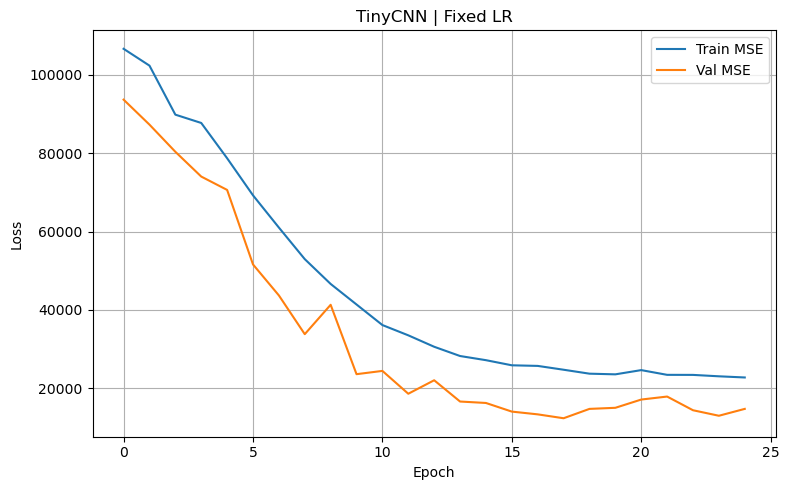

In [18]:
train_tiny_cnn()

In [25]:
import os, csv, random, math, time
from typing import Tuple, Optional
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms.functional as TF
from PIL import Image
import matplotlib.pyplot as plt

# ---------------------- TinyCNN ----------------------
class ConvBNReLU(nn.Module):
    def __init__(self, in_ch, out_ch, k=3, s=1, p=1):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, k, stride=s, padding=p, bias=False)
        self.bn   = nn.BatchNorm2d(out_ch, eps=1e-5, momentum=0.1)
        self.act  = nn.ReLU(inplace=True)
    def forward(self, x): return self.act(self.bn(self.conv(x)))

class TinyCNN(nn.Module):
    def __init__(self, in_ch=3, widths=(24,48,96,128), dropout=0.3, out_dim=1):
        super().__init__()
        w1,w2,w3,w4 = widths
        self.stem  = nn.Sequential(ConvBNReLU(in_ch,w1,3,2,1), ConvBNReLU(w1,w1,3,1,1))
        self.s1    = nn.Sequential(ConvBNReLU(w1,w2,3,2,1),  ConvBNReLU(w2,w2,3,1,1))
        self.s2    = nn.Sequential(ConvBNReLU(w2,w3,3,2,1),  ConvBNReLU(w3,w3,3,1,1))
        self.s3    = nn.Sequential(ConvBNReLU(w3,w4,3,2,1),  ConvBNReLU(w4,w4,3,1,1))
        self.drop  = nn.Dropout(dropout)
        self.fc1   = nn.Linear(w4, 128)
        self.fc2   = nn.Linear(128, out_dim)
    def forward(self, x):
        f = self.s3(self.s2(self.s1(self.stem(x))))
        z = F.adaptive_avg_pool2d(f, 1).flatten(1)
        z = self.drop(F.relu(self.fc1(z), inplace=True))
        return self.fc2(z)

# ---------------------- Dataset ----------------------
class RGBDataset(Dataset):
    """CSV columns: dish_id,label,rgb_path"""
    def __init__(self, csv_file, out_size=(384,384), augment=True,
                 mean_rgb=(0.485,0.456,0.406), std_rgb=(0.229,0.224,0.225)):
        super().__init__()
        self.H, self.W = out_size
        self.augment = augment

        self.rows = []
        with open(csv_file, "r") as f:
            reader = csv.reader(f)
            header = next(reader)
            col = {h:i for i,h in enumerate(header)}
            for r in reader:
                self.rows.append({
                    "dish_id": r[col["dish_id"]],
                    "label": float(r[col["label"]]),
                    "rgb": r[col["rgb_path"]],
                })

        self.mean_rgb = torch.tensor(mean_rgb).view(3,1,1)
        self.std_rgb  = torch.tensor(std_rgb ).view(3,1,1)

    def _load_img(self, p): return TF.to_tensor(Image.open(p).convert("RGB"))

    def _augment(self, img):
        scale = random.uniform(0.7, 1.0)
        h,w = img.shape[-2:]
        th,tw = int(h*scale), int(w*scale)
        i = random.randint(0, h-th) if th < h else 0
        j = random.randint(0, w-tw) if tw < w else 0
        img = TF.resized_crop(img, i, j, th, tw, (self.H,self.W))
        ang = random.uniform(-8,8)
        img = TF.rotate(img, ang)
        if random.random() < 0.5: img = TF.hflip(img)
        img = TF.adjust_brightness(img,1+random.uniform(-0.2,0.2))
        img = TF.adjust_contrast(img,1+random.uniform(-0.2,0.2))
        img = TF.adjust_saturation(img,1+random.uniform(-0.2,0.2))
        img = TF.adjust_hue(img,random.uniform(-0.04,0.04))
        return img

    def __getitem__(self, idx):
        row = self.rows[idx]
        y = torch.tensor([row["label"]], dtype=torch.float32)
        rgb = self._load_img(row["rgb"])
        if self.augment:
            rgb = self._augment(rgb)
        else:
            rgb = TF.resize(rgb, (self.H,self.W))
        rgb = (rgb - self.mean_rgb) / (self.std_rgb + 1e-6)
        return rgb, y, row["dish_id"]

    def __len__(self): return len(self.rows)

# ---------------------- Utils ----------------------
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

def make_loader(dataset, batch_size, shuffle, drop_last):
    num_workers = 0
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle,
                      num_workers=num_workers, pin_memory=torch.cuda.is_available(),
                      drop_last=drop_last)

# ---------------------- Eval / Train ----------------------
@torch.no_grad()
def evaluate(model, loader, device):
    model.eval(); mse_sum=mae_sum=n=0.0
    for x,y,_ in loader:
        x,y=x.to(device, non_blocking=True),y.to(device, non_blocking=True)
        p=model(x)
        mse_sum+=F.mse_loss(p,y,reduction="sum").item()
        mae_sum+=torch.abs(p-y).sum().item(); n+=y.size(0)
    return {"MSE":mse_sum/n,"MAE":mae_sum/n}

def train_one_epoch(model, loader, optimizer, device, max_grad_norm=1.0):
    model.train()
    total, n = 0.0, 0
    for x, y, _ in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        pred = model(x)
        loss = F.mse_loss(pred, y)
        loss.backward()
        if max_grad_norm is not None:
            nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        total += loss.item() * x.size(0)
        n     += x.size(0)
    return total / max(1, n)

# ---------------------- Main ----------------------
def train_tiny_cnn_only_color():
    set_seed(7)
    device = "cuda" if torch.cuda.is_available() else "cpu"

    train_csv = "train_index.csv"
    idx = list(range(len(RGBDataset(train_csv, augment=False))))
    random.shuffle(idx)
    k = max(1, int(0.2 * len(idx)))
    val_idx, train_idx = idx[:k], idx[k:]

    train_full = RGBDataset(train_csv, augment=True)
    val_full   = RGBDataset(train_csv, augment=False)
    train_ds = Subset(train_full, train_idx)
    val_ds   = Subset(val_full,   val_idx)

    train_loader = make_loader(train_ds, batch_size=64, shuffle=True,  drop_last=True)
    val_loader   = make_loader(val_ds,   batch_size=64, shuffle=False, drop_last=False)

    model = TinyCNN(in_ch=3, widths=(24,48,96,128), dropout=0.3, out_dim=1).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

    train_losses, val_losses = [], []
    best_val = float("inf")
    EPOCHS = 35

    for ep in range(1, EPOCHS + 1):
        tr = train_one_epoch(model, train_loader, optimizer, device)
        val = evaluate(model, val_loader, device)
        train_losses.append(tr); val_losses.append(val["MSE"])
        print(f"Epoch {ep:03d} | Train {tr:.4f} | Val MSE {val['MSE']:.4f} | Val MAE {val['MAE']:.2f}")
        if val["MSE"] < best_val:
            best_val = val["MSE"]
            torch.save({
                "model": model.state_dict(),
                "mode": "rgb",
                "in_ch": 3,
            }, "tinycnn_rgb_best.pth")

    plt.figure(figsize=(8,5))
    plt.plot(train_losses, label="Train MSE")
    plt.plot(val_losses, label="Val MSE")
    plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.title("TinyCNN (RGB Only)")
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()


Epoch 001 | Train 107331.1360 | Val MSE 94761.3258 | Val MAE 226.69
Epoch 002 | Train 105034.0566 | Val MSE 93330.0633 | Val MAE 224.39
Epoch 003 | Train 102953.4485 | Val MSE 90564.8884 | Val MAE 219.89
Epoch 004 | Train 99894.6648 | Val MSE 88930.7739 | Val MAE 218.18
Epoch 005 | Train 96158.3917 | Val MSE 85730.1684 | Val MAE 213.43
Epoch 006 | Train 92688.2928 | Val MSE 81722.1284 | Val MAE 206.95
Epoch 007 | Train 88681.2929 | Val MSE 72681.6773 | Val MAE 192.23
Epoch 008 | Train 84817.0049 | Val MSE 72904.8669 | Val MAE 193.33
Epoch 009 | Train 80730.2137 | Val MSE 75899.1313 | Val MAE 198.97
Epoch 010 | Train 76166.2190 | Val MSE 65760.4794 | Val MAE 181.02
Epoch 011 | Train 71947.8014 | Val MSE 58156.3280 | Val MAE 169.02
Epoch 012 | Train 66926.7700 | Val MSE 59329.3420 | Val MAE 171.53
Epoch 013 | Train 62242.0628 | Val MSE 46110.0504 | Val MAE 147.59
Epoch 014 | Train 58197.6981 | Val MSE 40972.8891 | Val MAE 138.04
Epoch 015 | Train 53940.7698 | Val MSE 49614.9057 | Val MAE

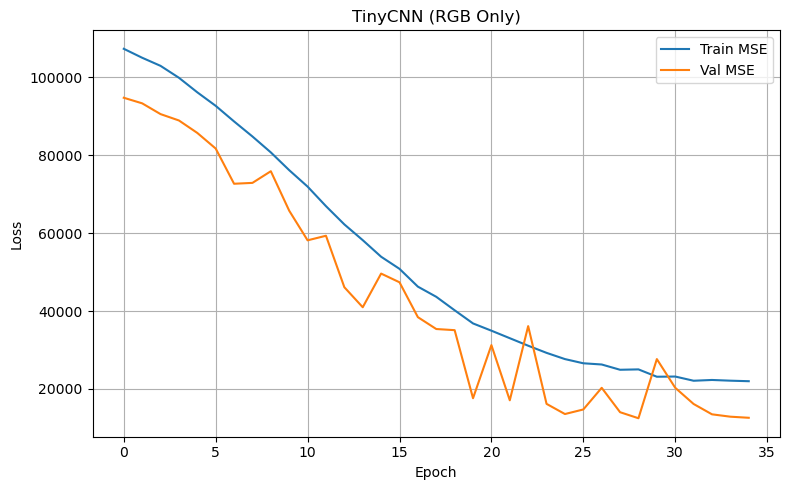

In [26]:
train_tiny_cnn_only_color()